In [1]:
# The term you are looking for to find the best choice of parameters when you have data values:
# supervised dimensionality reduction

%pylab inline
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import scipy.interpolate as interpolate
import scipy.integrate as integrate
import scipy.optimize as optimize

Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib
matplotlib.__version__

'2.0.0rc1'

In [3]:
sys.path.insert(0, '../src')

import waveform as wave
import waveformset as ws
import trainingset as train
import taylorf2 as f2
import gaussianprocessregression as gpr
import designofexperiment as doe
#import pycbcwaveform as pycbcwave
import lalwaveform
import plotparams
import greedy
import empiricalinterpolation as eim
import surrogate
import diagnostics

import imp
imp.reload(wave)
imp.reload(ws)
imp.reload(train)
imp.reload(f2)
imp.reload(gpr)
imp.reload(doe)
#imp.reload(pycbcwave)
imp.reload(lalwaveform)
imp.reload(greedy)
imp.reload(eim)
imp.reload(surrogate)
imp.reload(diagnostics)

import constants
imp.reload(constants)
from constants import *

# Get saved training-set waveforms

In [4]:
#trainset = ws.HDF5WaveformSet('../data/dh_training_set_p00015.hdf5')
# trainset = ws.HDF5WaveformSet('../data/dh_training_set_p00015_n1056.hdf5')
# trainset = ws.HDF5WaveformSet('../data/dh_training_set_join_p00015.hdf5')
# trainset = ws.HDF5WaveformSet('../data/dh_training_set_p00015_n50.hdf5')
# trainset = ws.HDF5WaveformSet('../data/dh_training_set_join_n50_rmsphase_p00015.hdf5')
# trainset = ws.HDF5WaveformSet('../data/dh_training_set_join_350_p00015.hdf5')
trainset = ws.HDF5WaveformSet('../data/dh_training_set_join_475_p00015.hdf5')
len(trainset)

475

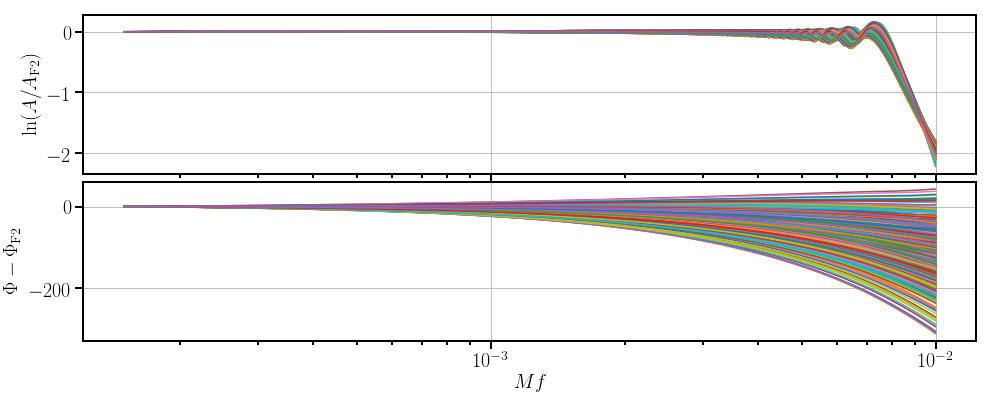

In [5]:
fig, (ax1, ax2) = wave.plot_waveforms_fd([trainset[i] for i in range(0, len(trainset), 1)])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate reduced Bases for amplitude and phase

In [6]:
epsilon = 1.0e-7

# Initialize the ReducedBasis object
add = surrogate.add_amp
subtract = surrogate.subtract_amp
scalar_multiply = surrogate.scalar_multiply_amp
inner_product = surrogate.inner_product_amp

get_waveform = trainset.get_waveform

ts_params = trainset.parameters()
rbamprun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbamprun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

1.0
0.0668611675457
0.00396504789195
0.00239580325907
0.00212351804537
0.000897524252231
0.000594305795017
0.000404651406186
0.000129987604956
0.00011394606719
9.99707943371e-05
9.37189670208e-05
4.11521464605e-05
2.95496795615e-05
2.30119267439e-05
2.0585413629e-05
1.85314249984e-05
1.18104337373e-05
1.13540891884e-05
8.72928248097e-06
7.53104087248e-06
6.08539457869e-06
5.71421170381e-06
5.4383032233e-06
4.19255749573e-06
3.59430783214e-06
3.08241840763e-06
2.97118129333e-06
2.37675708359e-06
2.25351921246e-06
2.00200610967e-06
1.4538588109e-06
1.30859233771e-06
1.01001471053e-06
8.19622436254e-07
7.54466981556e-07
6.79246058621e-07
5.30573951329e-07
5.24740356722e-07
5.02395045676e-07
4.73550069713e-07
4.28183911549e-07
4.19437055643e-07
3.86145235898e-07
3.41295645301e-07
3.39573343222e-07
3.20741712523e-07
3.03118225076e-07
2.93713958377e-07
2.69372699035e-07
2.63772032438e-07
2.50782128619e-07
2.41303233506e-07
2.32901574693e-07
2.14106142371e-07
1.82829461459e-07
1.79529415889e-

In [7]:
len(rbamprun.rb)

67

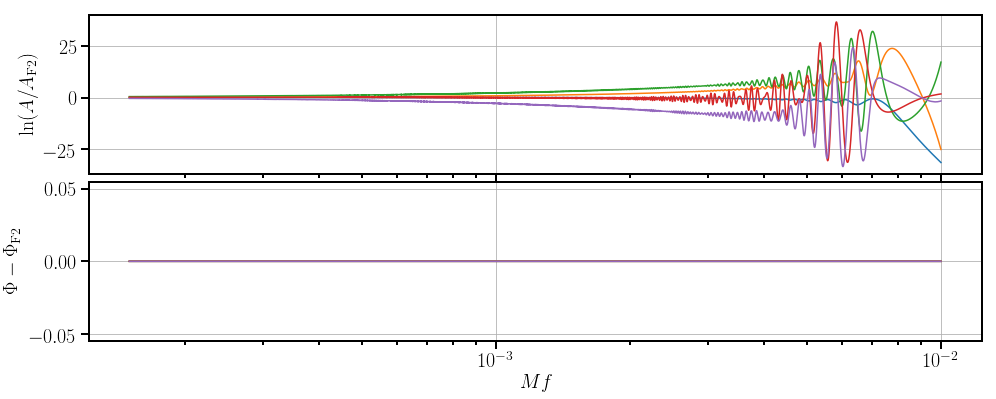

In [8]:
fig, (ax1, ax2) = wave.plot_waveforms_fd(rbamprun.rb[:5])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

In [9]:
epsilon = 1.0e-11

# Initialize the ReducedBasis object
add = surrogate.add_phase
subtract = surrogate.subtract_phase
scalar_multiply = surrogate.scalar_multiply_phase
inner_product = surrogate.inner_product_phase

get_waveform = trainset.get_waveform

ts_params = trainset.parameters()
rbphaserun = greedy.ReducedBasis(add, subtract, scalar_multiply, inner_product, get_waveform, ts_params)

# Standard method
rbphaserun.generate_reduced_basis(epsilon, ts_istart=0, Nbases=None)

1.0
0.998433440629
0.00952820098446
0.000508903406157
5.0432948147e-05
1.84140141308e-05
3.8462044698e-06
1.47816744422e-06
8.07854346196e-07
3.8490290577e-07
2.67907855345e-07
2.30341857477e-07
1.61123055231e-07
1.28104104213e-07
7.94288845807e-08
6.08527096491e-08
3.778570834e-08
3.25315487881e-08
2.54566265845e-08
1.98478488089e-08
1.49591338205e-08
1.08245121755e-08
1.0304808673e-08
4.37656388907e-09
3.439414753e-09
3.05440595039e-09
2.30454966221e-09
2.22292062535e-09
2.10171013926e-09
1.37582922832e-09
1.10267417419e-09
9.40700517482e-10
8.45388758997e-10
8.03159316831e-10
5.13375120192e-10
3.94520971447e-10
3.5028213663e-10
3.22927240504e-10
3.09518966013e-10
3.07840863911e-10
2.17724394069e-10
2.15504836198e-10
2.11466621991e-10
1.91278659578e-10
1.55146118175e-10
1.42477141196e-10
1.29985577857e-10
1.28503208074e-10
1.24603771745e-10
1.20588206087e-10
1.08463016346e-10
1.05534136985e-10
9.38562561004e-11
7.93961563161e-11
6.56785736908e-11
6.29430951804e-11
6.0253135814e-11
5.

In [10]:
len(rbphaserun.rb)

102

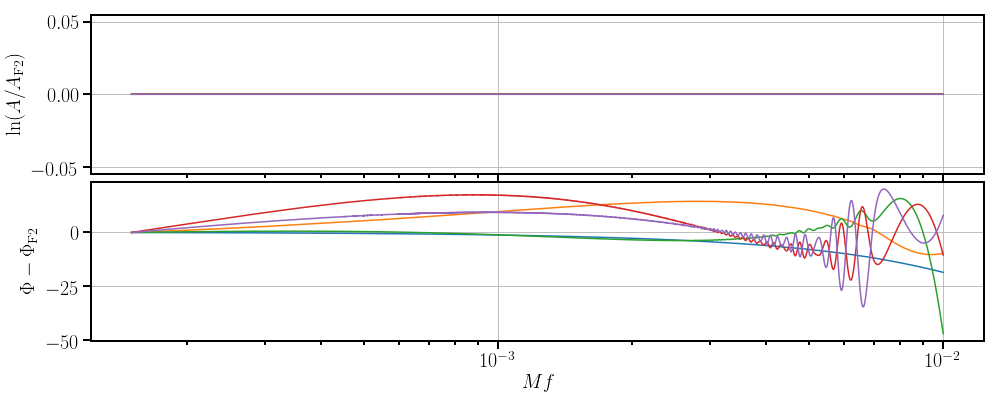

In [11]:
fig, (ax1, ax2) = wave.plot_waveforms_fd(rbphaserun.rb[:5])
ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate Empirical interpolating functions

In [15]:
def save_empirical_interpolating_function_list(filename, b_j, mf_node):
    """Save the empirical interpolating functions as a HDF5WaveformSet object.
    """
    bset = ws.HDF5WaveformSet(filename)
    
    for j in range(len(b_j)):
        # b_j don't have waveform parameters associated with them,
        # but you do want to save the node frequency node_mf 
        parameters = np.array([mf_node[j]])
        bset.set_waveform(j, b_j[j], parameters)
    
    bset.close()

In [16]:
# Use the first 20 bases
namp = 20
nphase = 20
empirical_node_indices_amp, Bamp_j = surrogate.empirical_interpolation_for_time_domain_waveform(
    rbamprun.rb[:namp], 'amp')
empirical_node_indices_phase, Bphase_j = surrogate.empirical_interpolation_for_time_domain_waveform(
    rbphaserun.rb[:nphase], 'phase')

In [17]:
# Get the frequencies Mf at each empirical node, and sort B's by the node frequency.

# amp
mf_amp = Bamp_j[0].x[empirical_node_indices_amp]
mf_Bamp_list = [[mf_amp[i], Bamp_j[i]] for i in range(len(mf_amp))]
mf_Bamp_list_sorted = sorted(mf_Bamp_list, key=lambda x: x[0])

# phase
mf_phase = Bphase_j[0].x[empirical_node_indices_phase]
mf_Bphase_list = [[mf_phase[i], Bphase_j[i]] for i in range(len(mf_phase))]
mf_Bphase_list_sorted = sorted(mf_Bphase_list, key=lambda x: x[0])

In [18]:
filename = '../data/Bamp_p00015_join_475.hdf5'
mf = [mf_Bamp_list_sorted[i][0] for i in range(len(mf_Bamp_list_sorted))]
B_j = [mf_Bamp_list_sorted[i][1] for i in range(len(mf_Bamp_list_sorted))]
save_empirical_interpolating_function_list(filename, B_j, mf)

filename = '../data/Bphase_p00015_join_475.hdf5'
mf = [mf_Bphase_list_sorted[i][0] for i in range(len(mf_Bphase_list_sorted))]
B_j = [mf_Bphase_list_sorted[i][1] for i in range(len(mf_Bphase_list_sorted))]
save_empirical_interpolating_function_list(filename, B_j, mf)

In [19]:
# Now load them
Bamp_j = ws.HDF5WaveformSet('../data/Bamp_p00015_join_475.hdf5')
Bphase_j = ws.HDF5WaveformSet('../data/Bphase_p00015_join_475.hdf5')

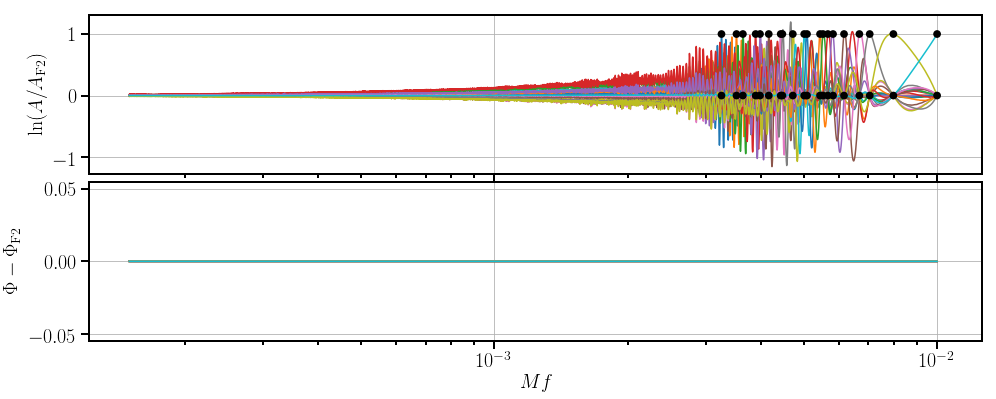

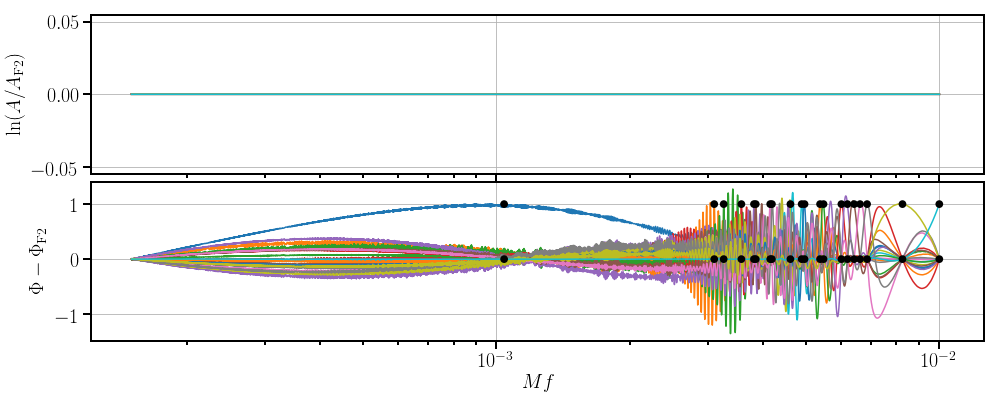

In [20]:
hs = [Bamp_j[j] for j in range(len(Bamp_j))]
mfs = np.array([Bamp_j.get_waveform(j, data='parameters')[0] for j in range(len(Bamp_j))])
fig, (ax1, ax2) = wave.plot_waveforms_fd(hs)
# zorder is order in which figure is drawn (placed on top of previous figures)
ax1.scatter(mfs, 0*mfs, marker='o', c='k', s=60, edgecolor='none', zorder=100)
ax1.scatter(mfs, 0*mfs+1, marker='o', c='k', s=60, edgecolor='none', zorder=100)

ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

hs = [Bphase_j[j] for j in range(len(Bphase_j))]
mfs = np.array([Bphase_j.get_waveform(j, data='parameters')[0] for j in range(len(Bphase_j))])
fig, (ax1, ax2) = wave.plot_waveforms_fd(hs)
# zorder is order in which figure is drawn (placed on top of previous figures)
ax2.scatter(mfs, 0*mfs, marker='o', c='k', s=60, edgecolor='none', zorder=100)
ax2.scatter(mfs, 0*mfs+1, marker='o', c='k', s=60, edgecolor='none', zorder=100)

ax1.set_ylabel(r'$\ln(A/A_{\rm F2})$')
ax2.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
ax2.set_xlabel(r'$Mf$')
ax1.grid()
ax2.grid()

# Generate Gaussian processes

In [21]:
# Calculate the amplitude for all waveforms in the training set
# at the amplitude empirical nodes
damp_ts_list = []
for j in range(len(Bamp_j)):
    mf = Bamp_j.get_waveform(j, data='parameters')[0]
    damp_ts = np.array([trainset[i].interpolate('amp')(mf) for i in range(len(trainset))])
    damp_ts_list.append(damp_ts)
    
# Calculate the phase for all waveforms in the training set
# at the phase empirical nodes
dphase_ts_list = []
for j in range(len(Bphase_j)):
    mf = Bphase_j.get_waveform(j, data='parameters')[0]
    dphase_ts = np.array([trainset[i].interpolate('phase')(mf) for i in range(len(trainset))])
    dphase_ts_list.append(dphase_ts)
    
# Relevant parameters for the training set waveforms
params_ts = trainset.parameters()

In [22]:
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'

damp_gp_list = []
for i in range(len(damp_ts_list)):
    print i
    points = params_ts
    data = damp_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits)
    damp_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    #print hp0
    print hyper_limits
    #print damp_gp.kernel_
    print gpr.get_hyperparameters(damp_gp)
    damp_gp_list.append(damp_gp)

0
[[  5.06872690e-03   2.02749076e-01]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  5.06872690e-07   5.06872690e-03]]
[  3.81434817e-02   1.55176110e+00   4.21879158e+00   5.60000000e+00
   4.00000000e+04   4.00000000e+04   1.70383491e-03]
1
[[  5.61166180e-03   2.24466472e-01]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  5.61166180e-07   5.61166180e-03]]
[  4.59779877e-02   1.71751093e+00   3.69651812e+00   4.84505630e+00
   4.00000000e+04   4.00000000e+04   2.41974206e-03]
2
[[  6.67713513e-03   2.67085405e-01]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  6.67

/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([  1.35646792e-05,  -8.88076647e-05,  -6.67572830e+01,
        -1.97837780e+02,  -1.48832407e-04,  -2.02136622e+02,
         1.09996238e-01]), 'nit': 22, 'funcalls': 68}
  " state: %s" % convergence_dict)


[[  5.98436644e-02   2.39374658e+00]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  5.98436644e-06   5.98436644e-02]]
[  9.83878616e-02   1.39435040e+00   5.60000000e+00   5.60000000e+00
   3.45497084e+04   4.00000000e+04   5.98436644e-06]
19
[[  2.23346883e-01   8.93387532e+00]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  2.23346883e-05   2.23346883e-01]]
[  2.74054596e-01   1.06849514e+00   5.60000000e+00   5.60000000e+00
   4.00000000e+04   4.00000000e+04   2.23346883e-05]


In [23]:
limits = np.array([[1.0/3.0, 1.0], [-0.7, 0.7], [-0.7, 0.7], [0, 10000], [0, 10000]])
kernel_type = 'matern52'

dphase_gp_list = []
for i in range(len(dphase_ts_list)):
    print i
    points = params_ts
    data = dphase_ts_list[i]
    hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits, sigma_n_factor=[1.0e-6, 0.1])
#     hp0, hyper_limits = gpr.reasonable_hyperparameters_range(data, limits, 
#                                                              sigma_f_factor=[0.1, 10.0], 
#                                                              sigma_n_factor=[1.0e-5, 0.1], 
#                                                              length_scale_factor=[0.1, 10.0])
    dphase_gp = gpr.generate_gp(points, data, hp0, kernel_type=kernel_type, 
                                hyper_limits=hyper_limits, n_restarts_optimizer=9)
    #print hp0
    print hyper_limits
    #print dphase_gp.kernel_
    print gpr.get_hyperparameters(dphase_gp)
    dphase_gp_list.append(dphase_gp)

0
[[  2.50633962e+00   1.00253585e+02]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  2.50633962e-05   2.50633962e+00]]
[  8.46280845e+00   9.16945814e-01   2.91859091e+00   5.60000000e+00
   4.00000000e+04   4.00000000e+04   2.50633962e-05]
1
[[  8.75991190e+00   3.50396476e+02]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  8.75991190e-05   8.75991190e+00]]
[  2.40768780e+01   8.45006123e-01   3.66678334e+00   5.60000000e+00
   4.00000000e+04   4.00000000e+04   8.75991190e-05]
2
[[  9.24528480e+00   3.69811392e+02]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  9.24

/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:427: UserWarning: fmin_l_bfgs_b terminated abnormally with the  state: {'warnflag': 2, 'task': 'ABNORMAL_TERMINATION_IN_LNSRCH', 'grad': array([ -9.35725802e-05,   3.86529186e-04,   9.14579843e-05,
        -1.56195239e+02,  -2.76914741e+01,  -2.15905466e+02,
         1.84579343e-04]), 'nit': 35, 'funcalls': 83}
  " state: %s" % convergence_dict)


[[  1.02235274e+01   4.08941097e+02]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  1.02235274e-04   1.02235274e+01]]
[  2.74966969e+01   8.36661033e-01   3.80554744e+00   5.60000000e+00
   4.00000000e+04   4.00000000e+04   1.02235274e-04]
4
[[  1.09801327e+01   4.39205310e+02]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  1.09801327e-04   1.09801327e+01]]
[  2.92322031e+01   8.32218300e-01   3.87446451e+00   5.60000000e+00
   4.00000000e+04   4.00000000e+04   1.09801327e-04]
5
[[  1.10906946e+01   4.43627784e+02]
 [  6.66666667e-02   2.66666667e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.40000000e-01   5.60000000e+00]
 [  1.00000000e+03   4.00000000e+04]
 [  1.00000000e+03   4.00000000e+04]
 [  1.1090

In [24]:
filename = '../data/amp_gp_p00015_join_475.hdf5'
gp_list = damp_gp_list
kernel_type = 'matern52'
gpr.save_gaussian_process_regression_list(filename, gp_list, kernel_type)

filename = '../data/phase_gp_p00015_join_475.hdf5'
gp_list = dphase_gp_list
kernel_type = 'matern52'
gpr.save_gaussian_process_regression_list(filename, gp_list, kernel_type)

# Diagnosing GP fit

In [25]:
def symlog_yticks(axes):
    decade = np.array([0.1*i for i in range(10)])
    ticks = []
    for i in range(-1, 2):
        ticks.append(decade*10**i)
    ticks = np.concatenate(np.array(ticks))
    ticks_rev = np.flip(ticks, 0)
    all_ticks = np.concatenate((-ticks_rev, ticks)) 
    axes.set_yticks(all_ticks, minor=True)
    #axes.set_yticks(all_ticks)

In [26]:
dh_testset_uni = ws.HDF5WaveformSet('../data/dh_test_set_uniform_p00015.hdf5')

[  6.00000000e-01  -7.00000000e-01   2.00000000e-01   2.00000000e+03
   1.00000000e+03]


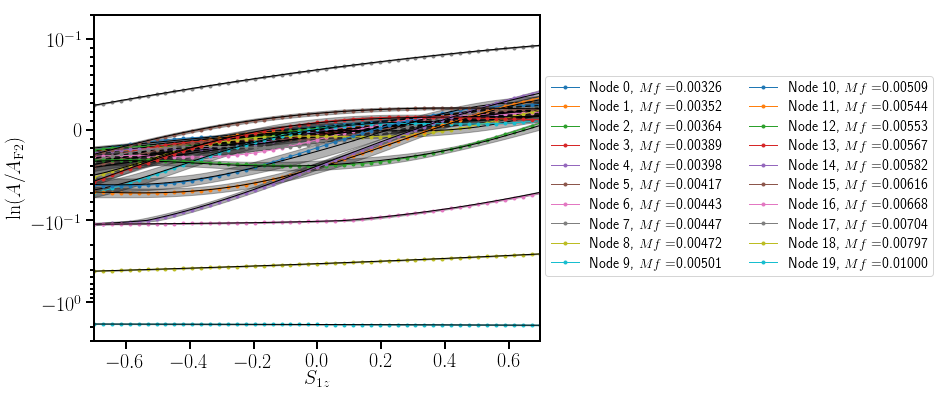

In [27]:
params_test = dh_testset_uni.parameters()
print params_test[0]

fig, axes = plt.subplots(1, figsize=(8, 6))
for j in range(len(damp_gp_list)):
    # Node frequency
    mf = Bamp_j.get_waveform(j, data='parameters')[0]
    
    # Values at node mf for test set and GP prediction/error
    damp_test = np.array([dh_testset_uni[i].interpolate('amp')(mf) for i in range(len(dh_testset_uni))])
    damp_gp = damp_gp_list[j]
    damp_gp_eval, damp_gp_eval_err = damp_gp.predict(params_test, return_std=True)
    
    axes.plot(params_test[:, 1], damp_test, 'o', ls='-', lw=1, ms=3,
             label='Node {}, $Mf=${:.5f}'.format(j, mf))
    axes.plot(params_test[:, 1], damp_gp_eval, ls='-', lw=1, c='k')
    axes.fill_between(params_test[:, 1], damp_gp_eval-damp_gp_eval_err, damp_gp_eval+damp_gp_eval_err, 
                      color='k', alpha=0.3)

axes.set_yscale('symlog', linthreshy=0.1)
#axes.set_yticks(ticks, minor=True)
symlog_yticks(axes)
axes.set_ylim(-3, 0.2)
axes.set_xlim(-0.7, 0.7)
axes.set_ylim()
axes.set_ylabel(r'$\ln(A/A_{\rm F2})$')
axes.set_xlabel(r'$S_{1z}$')
axes.legend(loc=(1.01, 0.2), ncol=2)

[  6.00000000e-01  -7.00000000e-01   2.00000000e-01   2.00000000e+03
   1.00000000e+03]


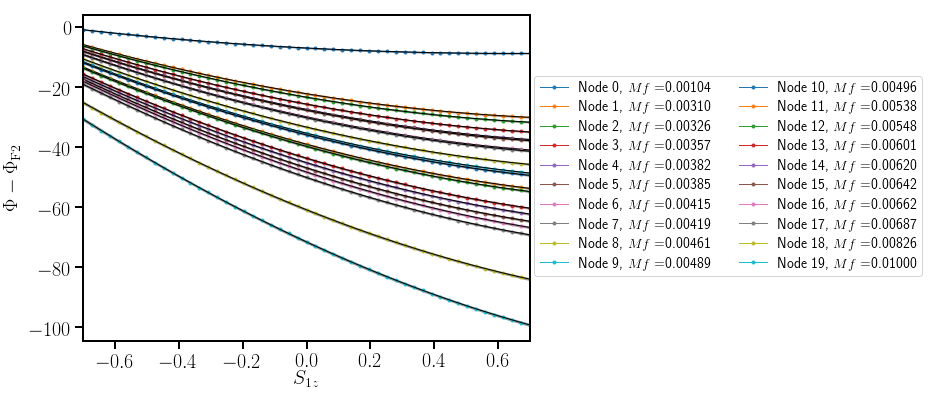

In [28]:
params_test = dh_testset_uni.parameters()
print params_test[0]

fig, axes = plt.subplots(1, figsize=(8, 6))
for j in range(len(dphase_gp_list)):
    # Node frequency
    mf = Bphase_j.get_waveform(j, data='parameters')[0]
    
    # Values at node mf for test set and GP prediction/error
    dphase_test = np.array([dh_testset_uni[i].interpolate('phase')(mf) for i in range(len(dh_testset_uni))])
    dphase_gp = dphase_gp_list[j]
    dphase_gp_eval, dphase_gp_eval_err = dphase_gp.predict(params_test, return_std=True)
    
    axes.plot(params_test[:, 1], dphase_test, 'o', ls='-', lw=1, ms=3,
             label='Node {}, $Mf=${:.5f}'.format(j, mf))
    axes.plot(params_test[:, 1], dphase_gp_eval, ls='-', lw=1, c='k')
    axes.fill_between(params_test[:, 1], dphase_gp_eval-dphase_gp_eval_err, dphase_gp_eval+dphase_gp_eval_err, 
                      color='k', alpha=0.3)

axes.set_xlim(-0.7, 0.7)
axes.set_ylim()
axes.set_ylabel(r'$\Phi-\Phi_{\rm F2}$')
axes.set_xlabel(r'$S_{1z}$')
axes.legend(loc=(1.01, 0.2), ncol=2)

# Diagnostics (Everything below should go in separate notebooks)

# Plot frequency dependent error estimates

In [167]:
Bamp_filename = '../data/Bamp.hdf5'
Bphase_filename = '../data/Bphase.hdf5'
damp_gp_filename = '../data/amp_gp.hdf5'
dphase_gp_filename = '../data/phase_gp.hdf5'

Bamp = ws.HDF5WaveformSet(Bamp_filename)
Bphase = ws.HDF5WaveformSet(Bphase_filename)
damp_gp_list = gpr.load_gaussian_process_regression_list(damp_gp_filename)
dphase_gp_list = gpr.load_gaussian_process_regression_list(dphase_gp_filename)

In [168]:
def error_of_frequency(point, B_j, gp_list, data='amp'):
    jmax = len(B_j)
    eps_f_j = np.array([gp_list[j].predict(np.atleast_2d(point), return_std=True)[1][0] 
                        for j in range(jmax)])
    
    # Get complex version of B_j's in array form
    if data=='amp':
        B_j_array = np.array([B_j[j].amp for j in range(jmax)])
    elif data=='phase':
        B_j_array = np.array([B_j[j].phase for j in range(jmax)])
    else:
        raise Exception

    # Evaluate waveform
    error_arr = np.dot(eps_f_j, B_j_array)

    # Rewrite as TimeDomainWaveform
    xarr = B_j[0].x
    return xarr, error_arr

In [177]:
point = np.array([0.8, 0.3, 0.7, 3455, 2579])
f, eps = error_of_frequency(point, Bamp, damp_gp_list, data='amp')
#f, eps = error_of_frequency(point, Bphase, dphase_gp_list, data='phase')

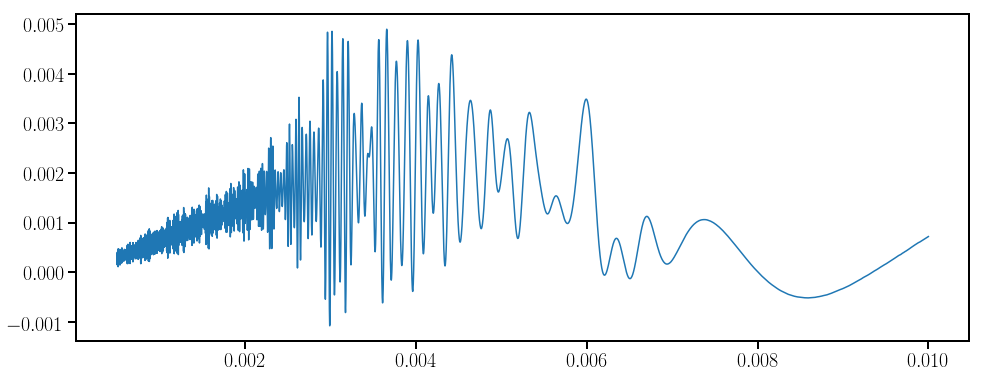

In [178]:
fig, ax1 = plt.subplots(1, figsize=(16, 6))
ax1.plot(f, eps)
#ax1.set_xscale('log')
#ax1.set_xlim(1.0e-4, 0.1)

0.00304761357728


/Users/lackey/Library/Python/2.7/lib/python/site-packages/sklearn/gaussian_process/gpr.py:308: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "
/Users/lackey/Library/Python/2.7/lib/python/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


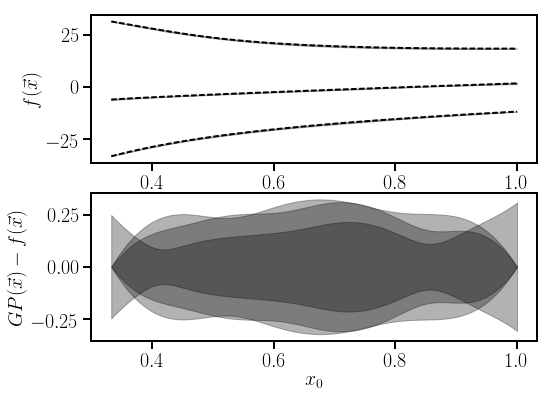

In [184]:
#x2, x3, x4 = 0.0, 2000.0, 2000.0
#x0, x1, x2, x3, x4 = params_rand[i_phasemax]
x0, x1, x2, x3, x4 = 1.0/3.0, -0.7, -0.7, 0.0, 0.0
i = 2
mf = Bphase_j.get_waveform(i, data='parameters')[0]
print mf
gp = dphase_gp_list[i]

fig, ax = plt.subplots(2, figsize=(8, 6))
for x1 in np.linspace(-0.7, 0.7, 3):
    x0s = np.linspace(1.0/3.0, 1.0, 100)
    ps = np.array([[x0, x1, x2, x3, x4] for x0 in x0s])
    
    #true = np.array([func(p) for p in ps])
    #ax[0].plot(xs, true, label=r'$x_1$='+str(x1))
    
    y_pred, ysigma = gp.predict(ps, return_std=True)
    ax[0].plot(x0s, y_pred, c='k', ls='--', lw=2)
    ax[0].fill_between(x0s, y_pred-ysigma, y_pred+ysigma, color='k', alpha=0.3)
    
    #ax[1].plot(x0s, (y_pred-true), label=r'$x_1$='+str(x1))
    ax[1].fill_between(x0s, -ysigma, ysigma, color='k', alpha=0.3)

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
#ax[1].set_ylim(-0.1, 0.1)
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))